# Réseau de neurones

## Import packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Dense
import cv2 as cv
from sklearn import preprocessing

___

## Implémentation en code python

Création de la fonction python permettant de produire différents réseayx de neurones de type perceptron multicouches. 

Pour la création du model, elle se fait couche par couche. Nous avons un modèle de type perceptron multi-couches avec : 
- une couche d'entrée
- deux couches cachées de 128 neurones avec des activations (ReLU par défaut mais peut être modifié)
- une couche de sortie de 10 neurones avec activation Softmax car en sortie nous avons un label, plusieurs classes 

Puis nous avons configuré la méthode d'entrainement de ce modèle en prenant en compte plusieurs critères : 
- optimizer : algorithme d'optimisation utilisé (par défaut adam mais peut être modifié) 
- loss : la fonction objectif que l'on souhaite minimiser (ici categorical_crossentropy)
- metrics : la métrique considée pour évaluer les performances (ici accuracy)
Puis, on peut entraîner le modèle en précisiant la façon dont les données seront résentées lors de l'entrainement : 
- epochs : un passage sur l'ensemble des données de la base d'entrainement (par défaut 20 mais peut être modifié) 
- batch_size : définit le nombre d'exemples qui seront propagés à chaque itération pour calculer la mise à jour des poids (par défaut 128 mais peut être modifié) 

Ensuite, on ajuste le modèle : on l'entraîne sur nos données dans train. Où : 
- epochs : nombre de fois qu'il faut itérer sur les tableaux de données 
- batch_size : nombre d'échantillon par mise à jour du gradient 
- callbacks : objet qui peut effectuer des actions à différentes étapes de la formation 
    - soit vide 
    - soit qui a été crée par nous même avec callbacks.EarlyStopping : 
        - monitor : quantité à surveiller (ici les pertes "loss") 
        - mode : mode (ici "min") 
        - patience : nombre d'époch sans amélioration après lesquelles l'entrainement sera arrêté (ici 4) 
        - restore_best_weights : si il faut rester les poids du modèle à partir de l'époch avec la meilleure valeur de la quantité surveillé (ici vrai) 
        - verbose : mode de verbosité (ici 2 : une ligne de journal par époch) 
        - validation_data : (ici x_validate et y_validate)

Pour finir, nous avons cherché à valider notre modèle. En effet nous regardons si le modèle est le mieux adapté au problème donné et aux données correspondantes. Pour cela, nous avons besoin des données de test et leurs étiquettes. On rentre également le nombre d'exemples à propagés pour chaque itération. 

In [2]:
def mlp_model(train_set, test_set, validate_set, optimizer_name='adam', nb_layer=3, batch_size=128, learning_rate=0.001, epochs=20, activation_function="relu", callback_application = True):
    """
    abc xyz
    :param optimizer_name:
    :param batch_size:
    :param train_set:
    :param test_set:
    :param validate_set: qsdqsd
    :param learning_rate: something
    :param activation_function: ......
    :param epochs: number of ....
    :param nb_layer: number of layers
    """
    model = keras.models.Sequential([
        # deux couches cachées de 128 neurones avec activation ReLU par défaut
        Dense(128, activation=activation_function),
        Dense(128, activation=activation_function),
        # une couche de sortie de 10 neurones avec activation Softmax
        Dense(10, activation='softmax')
    ])

    x_train = train_set[0]
    y_train = train_set[1]
    x_test = test_set[0]
    y_test = test_set[1]
    x_validate = validate_set[0]
    y_validate = validate_set[1]

    optimizer = None
    if optimizer_name == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    if callback_application : 
        callback = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=4, restore_best_weights=True)
    else : 
        callback = []
    model_fit = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=2, validation_data=(x_validate, y_validate))
    
    model_score = model.evaluate(x_test, y_test, batch_size=batch_size)

    return model, model_fit, model_score

---

## Préparation des données

Nous effectuons des pré-traitement sur les données d'entrée à travers différentes fonctions :  

### Normaliser les données

In [17]:
def normalize(x):
    return x / 255

### Standardiser les données 

Standardiser les données en supprimant la moyenne et en mettant à l'échelle la variance unitaire

In [18]:
def standardize(x):
    scaler = preprocessing.StandardScaler().fit(x)
    x_scaled = scaler.transform(x)
    return x_scaled

### Seuillage manuelle

Appliquer un seuillage manuelle sur une image et contient plusieurs paramètres
- image à traiter
- valeur du seuil (0.5 par défaut) 
- la couleur que prendra les objets une fois seuillé (ici 1)
- type de seuilr (ici TRESH_BINARY)

In [19]:
def img_preprocessing(x, threshold=0.5):
    return cv.threshold(x, threshold, 1, cv.THRESH_BINARY)[1]

### Représentation des 25 premières images

- prépration du jeu de données pour qu'il soit conforme : donne une nouvelle "shape"
- plt.subplot : création d'une figure avec 5x5 grilles de sous-parcelles 
- plt.xticks : définir les emplacements des graduations de l'axe x
- plt.yticks : définir les emplacements des graduations de l'axe y
- plt.grid : si on veut afficher les grilles (ici non) 
- plt.imshow : afficher les données sous forme d'image (2D)

In [20]:
def display_img(x):
    plt.figure(figsize=(10, 10))
    x = x.reshape(len(x), 28, 28, 1)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.cm.binary)

### Préparation des nouveaux jeux de données

Appel du jeu de donénes mnist_all et création des jeux test, train et validate 
- Récupère dans Y les données de la première colonne du jeu de données car elles représentent les numéros qu'il faut avoir et dans X les données 
- train_test_split : divise nos jeux de donénes en sous-ensembles d'entraînement, de test et de validation. 
    - test_size permet de donner la proportion que nous voulons mettre dans d'abord test puis dans validate : 10% dans test, 10% dans validate et 80% dans train 
    - On l'applique 2 fois pour séparer en 3 fois le jeux de données initials 
- On normalise nos x (train, test, validate) 
- Si on le souhaite (en l'indiquant quand on appel la fonction) on peut appeler la fonction qui permet d'appliquer un seuil sur une image (ici sur nos x_train, x_test, x_validate)
- Convertir nos y (train, test, validate) en matrice de classe binaire 
- Afficher les états de nos nouveaux jeux de données 

In [21]:
def data_preparation(process_img=False):
    data = pd.read_csv("mnist_all.csv")
    x = np.array(data.iloc[:, 1:])
    y = data.iloc[:, 0]

    x_train_validate, x_test, y_train_validate, y_test = train_test_split(x, y, test_size=0.10, random_state=0, stratify=y)
    x_train, x_validate, y_train, y_validate = train_test_split(x_train_validate, y_train_validate, test_size=0.10, random_state=0, stratify=y_train_validate)

    x_train = normalize(x_train)
    x_test = normalize(x_test)
    x_validate = normalize(x_validate)

    if process_img:
        x_train = img_preprocessing(x_train)
        x_test = img_preprocessing(x_test)
        x_validate = img_preprocessing(x_validate)

    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    y_validate = keras.utils.to_categorical(y_validate, 10)

    print('shape X train : ', x_train.shape)
    print('shape X test : ', x_test.shape)
    print('shape X validate : ', x_validate.shape)
    print('shape Y train : ', y_train.shape)
    print('shape Y test : ', y_test.shape)
    print('shape Y validate : ', y_validate.shape)

    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]

---

## Elaboration de l'expérimentation

Maintenant, nous allons permettre l'affichage graphique des différentes informations. 

### Représentation de taux d'erreur et taux de réussite

Grâce à l'historique de model.fit (voir Implémentation en code Python) on peut récupérer plusieurs les métriques qui sont stocks dans un dictionnaire : 
- accuracy 
- val_accurary 
- loss 
- val_loss 

De ce fait, cela inclut la perte (loss) et la précision (accuracy) ainsi que la perte et la précision de l'ensemble de données de validation. Et nous pouvons créer des graphiques à partir de ces données. 

On créé un graphique de précision (accuracy) sur les ensembles de données d'entrainement et de validation sur les epochs d'entrainement. 

Puis un graphique de perte (loss) sur les ensembles de données d'entrainement et de validation en cours des epochs d'entrainement. 

In [24]:
def plot_model_result(model_fit):
    plt.subplot(2, 1, 1)
    plt.plot(model_fit.history['accuracy'])
    plt.plot(model_fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(2, 1, 2)
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.tight_layout()

### Enregistrement des modèles 

Enregistrer tous les modèles que nous avons effectué dans model_path. 

In [22]:
def save_model(model, model_name):
    save_dir = "./results/"
    model_path = save_dir + model_name
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

### Expérimentation 1
Description de l'expérimentation 1
* optimizer: SGD
* learning rate: 0.001
* epochs: 20
* process image method: None
* activation function: *relu*
* callback : *EarlyStopping*

In [5]:
train, test, validate = data_preparation(process_img=False)

shape X train :  (56699, 784)
shape X test :  (7000, 784)
shape X validate :  (6300, 784)
shape Y train :  (56699, 10)
shape Y test :  (7000, 10)
shape Y validate :  (6300, 10)


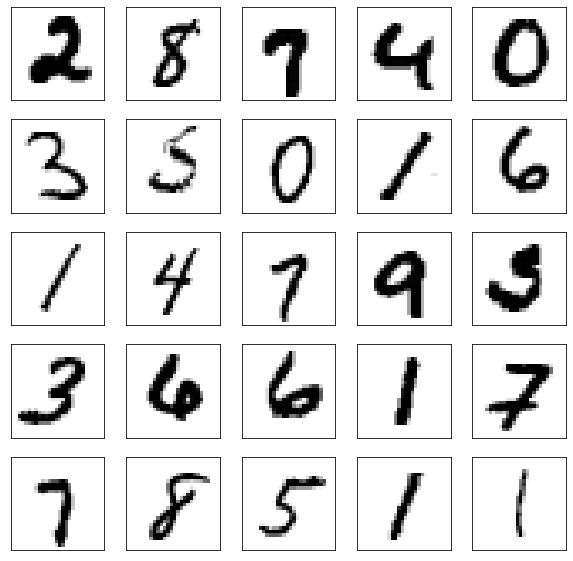

In [6]:
display_img(train[0])

In [7]:
model, model_fit, score = mlp_model(train_set=train, test_set=test,
                                    validate_set=validate, optimizer_name="sgd", nb_layer=3, learning_rate=0.001, epochs=20,
                                    activation_function="relu")
print(score)
save_model(model, "model1")

Epoch 1/20
443/443 - 3s - loss: 1.3341 - accuracy: 0.6767 - val_loss: 0.6715 - val_accuracy: 0.8311 - 3s/epoch - 8ms/step
Epoch 2/20
443/443 - 1s - loss: 0.5262 - accuracy: 0.8642 - val_loss: 0.4457 - val_accuracy: 0.8822 - 924ms/epoch - 2ms/step
Epoch 3/20
443/443 - 1s - loss: 0.4012 - accuracy: 0.8900 - val_loss: 0.3768 - val_accuracy: 0.8933 - 917ms/epoch - 2ms/step
Epoch 4/20
443/443 - 1s - loss: 0.3517 - accuracy: 0.9011 - val_loss: 0.3403 - val_accuracy: 0.9017 - 933ms/epoch - 2ms/step
Epoch 5/20
443/443 - 1s - loss: 0.3222 - accuracy: 0.9082 - val_loss: 0.3173 - val_accuracy: 0.9116 - 929ms/epoch - 2ms/step
Epoch 6/20
443/443 - 1s - loss: 0.3012 - accuracy: 0.9144 - val_loss: 0.2993 - val_accuracy: 0.9149 - 935ms/epoch - 2ms/step
Epoch 7/20
443/443 - 1s - loss: 0.2849 - accuracy: 0.9186 - val_loss: 0.2861 - val_accuracy: 0.9184 - 923ms/epoch - 2ms/step
Epoch 8/20
443/443 - 1s - loss: 0.2709 - accuracy: 0.9227 - val_loss: 0.2733 - val_accuracy: 0.9224 - 934ms/epoch - 2ms/step
Epo

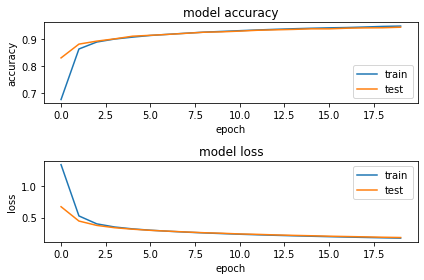

In [8]:
plot_model_result(model_fit)

---

### Expérimentation 2
Description de l'expérimentation 2
* optimizer: *SGD*
* learning rate: *0.001*
* epochs: *40*
* process image method: [binary threshold](https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html)
* activation function: *relu*
* callback : *EarlyStopping*

In [9]:
train, test, validate = data_preparation(process_img=True)

shape X train :  (56699, 784)
shape X test :  (7000, 784)
shape X validate :  (6300, 784)
shape Y train :  (56699, 10)
shape Y test :  (7000, 10)
shape Y validate :  (6300, 10)


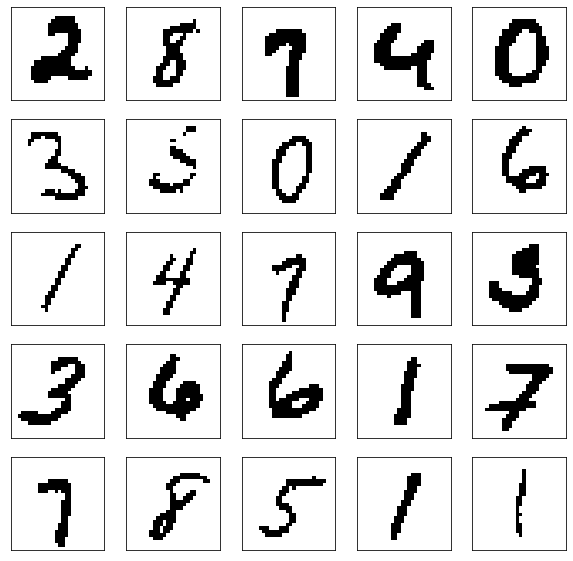

In [10]:
display_img(train[0])

In [11]:
model, model_fit, score = mlp_model(train_set=train, test_set=test,
                                    validate_set=validate, optimizer_name="sgd", nb_layer=3, learning_rate=0.001, epochs=40, activation_function="relu")
print(score)
save_model(model, "model2")

Epoch 1/40
443/443 - 1s - loss: 1.3908 - accuracy: 0.6360 - val_loss: 0.6870 - val_accuracy: 0.8248 - 1s/epoch - 3ms/step
Epoch 2/40
443/443 - 1s - loss: 0.5372 - accuracy: 0.8581 - val_loss: 0.4517 - val_accuracy: 0.8760 - 1s/epoch - 2ms/step
Epoch 3/40
443/443 - 1s - loss: 0.4104 - accuracy: 0.8845 - val_loss: 0.3827 - val_accuracy: 0.8921 - 1s/epoch - 2ms/step
Epoch 4/40
443/443 - 1s - loss: 0.3611 - accuracy: 0.8974 - val_loss: 0.3483 - val_accuracy: 0.9006 - 1s/epoch - 3ms/step
Epoch 5/40
443/443 - 1s - loss: 0.3322 - accuracy: 0.9047 - val_loss: 0.3272 - val_accuracy: 0.9051 - 1s/epoch - 3ms/step
Epoch 6/40
443/443 - 1s - loss: 0.3114 - accuracy: 0.9101 - val_loss: 0.3107 - val_accuracy: 0.9092 - 1s/epoch - 3ms/step
Epoch 7/40
443/443 - 1s - loss: 0.2947 - accuracy: 0.9147 - val_loss: 0.2959 - val_accuracy: 0.9125 - 1s/epoch - 2ms/step
Epoch 8/40
443/443 - 1s - loss: 0.2806 - accuracy: 0.9195 - val_loss: 0.2844 - val_accuracy: 0.9159 - 1s/epoch - 2ms/step
Epoch 9/40
443/443 - 1s 

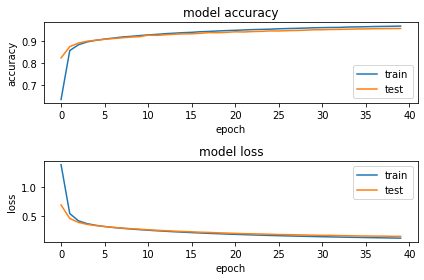

In [12]:
plot_model_result(model_fit)

---

### Expérimentation 3
Description de l'expérimentation 3
* optimizer: *Adam*
* learning rate: *0.01*
* epochs: *40*
* process image method: *None*
* activation function: *sigmoid*
* callback : vide

In [13]:
train, test, validate = data_preparation(process_img=False)

shape X train :  (56699, 784)
shape X test :  (7000, 784)
shape X validate :  (6300, 784)
shape Y train :  (56699, 10)
shape Y test :  (7000, 10)
shape Y validate :  (6300, 10)


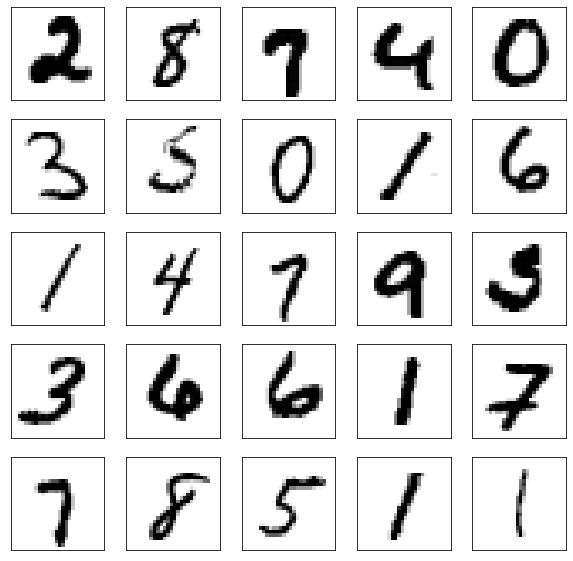

In [14]:
display_img(train[0])

In [26]:
model, model_fit, score = mlp_model(train_set=train, test_set=test,
                                    validate_set=validate, optimizer_name="adam", nb_layer=3, learning_rate=0.01, epochs=40, 
                                    activation_function="sigmoid", callback_application = False)
print(score)
save_model(model, "model3")

Epoch 1/40
443/443 - 3s - loss: 0.3056 - accuracy: 0.9076 - val_loss: 0.1453 - val_accuracy: 0.9562 - 3s/epoch - 8ms/step
Epoch 2/40
443/443 - 2s - loss: 0.1099 - accuracy: 0.9660 - val_loss: 0.1109 - val_accuracy: 0.9656 - 2s/epoch - 5ms/step
Epoch 3/40
443/443 - 3s - loss: 0.0768 - accuracy: 0.9757 - val_loss: 0.1002 - val_accuracy: 0.9681 - 3s/epoch - 6ms/step
Epoch 4/40
443/443 - 3s - loss: 0.0617 - accuracy: 0.9806 - val_loss: 0.0918 - val_accuracy: 0.9722 - 3s/epoch - 6ms/step
Epoch 5/40
443/443 - 3s - loss: 0.0526 - accuracy: 0.9833 - val_loss: 0.0884 - val_accuracy: 0.9727 - 3s/epoch - 6ms/step
Epoch 6/40
443/443 - 2s - loss: 0.0429 - accuracy: 0.9860 - val_loss: 0.0965 - val_accuracy: 0.9724 - 2s/epoch - 5ms/step
Epoch 7/40
443/443 - 2s - loss: 0.0409 - accuracy: 0.9864 - val_loss: 0.0938 - val_accuracy: 0.9733 - 2s/epoch - 5ms/step
Epoch 8/40
443/443 - 2s - loss: 0.0344 - accuracy: 0.9888 - val_loss: 0.0955 - val_accuracy: 0.9741 - 2s/epoch - 5ms/step
Epoch 9/40
443/443 - 2s 

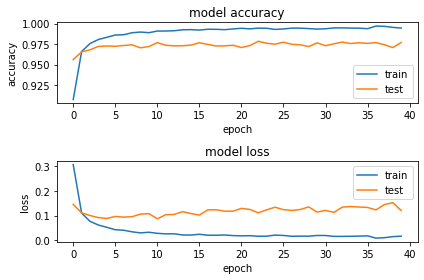

In [27]:
plot_model_result(model_fit)